In [1]:
import numpy as np
from model_vanilla_rot2d import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt
import os

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
file_name = 'rot2d_aug_argminW_alphamax20_lr0.0002'
out_dir_path = '/data/scratch/jahanian/mnist_dcgantf_bkup/out_old'
checkpoint_dir = os.path.join(out_dir_path,file_name,'checkpoint' )
sample_dir = os.path.join(out_dir_path,file_name,'sample' )
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

rot2d aug is disabled
loading mnist without augmenting ...
model_vanilla_rot2d ...
 [*] Reading checkpoints... /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/rot2d_aug_argminW_alphamax20_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/rot2d_aug_argminW_alphamax20_lr0.0002/checkpoint/model.b64-54400
 [*] Success to read model.b64-54400


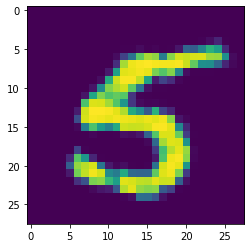

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    target_fn = np.copy(outputs_zs)
    mask_fn = np.ones(outputs_zs.shape)
#     print('rotate with alphas:', alpha)
    mask_out = np.zeros(outputs_zs.shape)

    for i in range(outputs_zs.shape[0]):
        if alpha!=0:
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), alpha, 1)
            target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
        else:
            mask_out[i,:,:,:] = mask_fn[i,:,:,:]

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

    if show_img:
        print('Target image:')
        imshow(imgrid(np.uint8(target_fn*255), cols=4))

    if show_mask:
        print('Target mask:')
        imshow(imgrid(np.uint8(mask_out*255), cols=4))

    return target_fn, mask_out


In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/rot2d_aug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 21)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-23 16:19:49,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.19160127639770508, 0, 0, 0.14081144332885742, 3
2019-09-23 16:19:49,093 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009535551071166992, 0, 10, 0.1974593549966812, -14
2019-09-23 16:19:49,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008980035781860352, 0, 20, 0.15432733297348022, 8
2019-09-23 16:19:49,113 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009305953979492188, 0, 30, 0.16111992299556732, -16
2019-09-23 16:19:49,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009227514266967773, 0, 40, 0.152427539229393, -11
2019-09-23 16:19:49,134 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009044647216796875, 0, 50, 0.14323897659778595, -5
2019-09-23 16:19:49,144 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009322881698608398, 0, 60, 0.13034801185131073, -5
2019-09-23 16:19:49,154 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009147405624389648, 0, 70, 0.11411856859922409, 3
2019-09-23 16:19:49,164 [Main

2019-09-23 16:19:49,766 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009148359298706055, 0, 670, 0.14319898188114166, 14
2019-09-23 16:19:49,776 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008924484252929688, 0, 680, 0.15617457032203674, 20
2019-09-23 16:19:49,786 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009029626846313477, 0, 690, 0.11424114555120468, -15
2019-09-23 16:19:49,796 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008837461471557617, 0, 700, 0.14819897711277008, 19
2019-09-23 16:19:49,806 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009338140487670898, 0, 710, 0.12410123646259308, -7
2019-09-23 16:19:49,817 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009148120880126953, 0, 720, 0.1294938325881958, -9
2019-09-23 16:19:49,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009469270706176758, 0, 730, 0.14243654906749725, -18
2019-09-23 16:19:49,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009402275085449219, 0, 740, 0.14051207900047302, 14
2019-09-23 16:1

2019-09-23 16:19:50,474 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009156942367553711, 0, 1340, 0.11004777252674103, 9
2019-09-23 16:19:50,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009077787399291992, 0, 1350, 0.0856841653585434, -18
2019-09-23 16:19:50,495 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009524822235107422, 0, 1360, 0.055399712175130844, 1
2019-09-23 16:19:50,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009162664413452148, 0, 1370, 0.09604456275701523, -14
2019-09-23 16:19:50,516 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009114980697631836, 0, 1380, 0.12966246902942657, 20
2019-09-23 16:19:50,526 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009431123733520508, 0, 1390, 0.11049289256334305, -19
2019-09-23 16:19:50,536 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00879526138305664, 0, 1400, 0.12592758238315582, 13
2019-09-23 16:19:50,547 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009236574172973633, 0, 1410, 0.10003668814897537, -6
2019-09-

Loss: [0.013443655729293824, 0.010542063653469085]
2019-09-23 16:19:51,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010169744491577148, 0, 2010, 0.10319916158914566, 10
2019-09-23 16:19:51,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010010719299316406, 0, 2020, 0.10587716102600098, -11
2019-09-23 16:19:51,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010083198547363281, 0, 2030, 0.09241273999214172, 3
2019-09-23 16:19:51,196 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009911537170410156, 0, 2040, 0.08847544342279434, -5
2019-09-23 16:19:51,206 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00970602035522461, 0, 2050, 0.085319384932518, 5
2019-09-23 16:19:51,217 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009772300720214844, 0, 2060, 0.10618491470813751, -15
2019-09-23 16:19:51,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010037899017333984, 0, 2070, 0.10328345000743866, 6
2019-09-23 16:19:51,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00971341133117

2019-09-23 16:19:51,874 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009383678436279297, 0, 2670, 0.09051854908466339, -14
2019-09-23 16:19:51,884 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009416341781616211, 0, 2680, 0.12229415029287338, -15
2019-09-23 16:19:51,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009541749954223633, 0, 2690, 0.10503815859556198, -10
2019-09-23 16:19:51,905 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009463310241699219, 0, 2700, 0.043624088168144226, 1
2019-09-23 16:19:51,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009619712829589844, 0, 2710, 0.11387360095977783, -7
2019-09-23 16:19:51,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009541511535644531, 0, 2720, 0.11529692262411118, -16
2019-09-23 16:19:51,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009572029113769531, 0, 2730, 0.11634182184934616, -17
2019-09-23 16:19:51,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010088682174682617, 0, 2740, 0.08332593739032745, 9
2019

2019-09-23 16:19:52,606 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009428024291992188, 0, 3330, 0.10171946883201599, 5
2019-09-23 16:19:52,617 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00986790657043457, 0, 3340, 0.08379653841257095, 3
2019-09-23 16:19:52,628 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009724140167236328, 0, 3350, 0.09184698015451431, -3
2019-09-23 16:19:52,638 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009523868560791016, 0, 3360, 0.12242844700813293, -10
2019-09-23 16:19:52,649 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009217977523803711, 0, 3370, 0.12225324660539627, -16
2019-09-23 16:19:52,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009529352188110352, 0, 3380, 0.08775180578231812, -15
2019-09-23 16:19:52,670 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00941610336303711, 0, 3390, 0.10819096863269806, -13
2019-09-23 16:19:52,680 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009428262710571289, 0, 3400, 0.11425812542438507, 17
2019-09-

2019-09-23 16:19:53,331 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009560108184814453, 0, 4000, 0.10113544017076492, 4
Loss: [0.013443655729293824, 0.010542063653469085, 0.0102301688157022, 0.010131466563791037]
2019-09-23 16:19:53,341 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009288311004638672, 0, 4010, 0.08719537407159805, 5
2019-09-23 16:19:53,352 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00932931900024414, 0, 4020, 0.11411017924547195, 13
2019-09-23 16:19:53,363 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009727716445922852, 0, 4030, 0.11170722544193268, 19
2019-09-23 16:19:53,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009382486343383789, 0, 4040, 0.1018475741147995, -8
2019-09-23 16:19:53,384 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009881019592285156, 0, 4050, 0.1108381375670433, -19
2019-09-23 16:19:53,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009508609771728516, 0, 4060, 0.12022203952074051, -6
2019-09-23 16:19:53,406 [MainThread  ] [INF

2019-09-23 16:19:54,052 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009255647659301758, 0, 4660, 0.11068356037139893, 19
2019-09-23 16:19:54,063 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00988149642944336, 0, 4670, 0.09615682810544968, 15
2019-09-23 16:19:54,074 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010065793991088867, 0, 4680, 0.03533146530389786, 1
2019-09-23 16:19:54,085 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009841203689575195, 0, 4690, 0.10045334696769714, 17
2019-09-23 16:19:54,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009653568267822266, 0, 4700, 0.09355324506759644, -16
2019-09-23 16:19:54,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009861469268798828, 0, 4710, 0.07713089883327484, 2
2019-09-23 16:19:54,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009785175323486328, 0, 4720, 0.1140483096241951, 8
2019-09-23 16:19:54,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009995222091674805, 0, 4730, 0.08649416267871857, 6
2019-09-23 16

2019-09-23 16:19:54,794 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009675979614257812, 0, 5320, 0.10001169145107269, 13
2019-09-23 16:19:54,804 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009879350662231445, 0, 5330, 0.07181466370820999, 2
2019-09-23 16:19:54,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009802818298339844, 0, 5340, 0.10163461416959763, -12
2019-09-23 16:19:54,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010369539260864258, 0, 5350, 0.09745999425649643, -7
2019-09-23 16:19:54,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009567499160766602, 0, 5360, 0.10650045424699783, -18
2019-09-23 16:19:54,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009490728378295898, 0, 5370, 0.04935048148036003, -1
2019-09-23 16:19:54,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009765386581420898, 0, 5380, 0.05054979771375656, -1
2019-09-23 16:19:54,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010229825973510742, 0, 5390, 0.09058965742588043, 10
2019-09

2019-09-23 16:19:55,528 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008834362030029297, 0, 5990, 0.10854911059141159, 16
2019-09-23 16:19:55,538 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008730173110961914, 0, 6000, 0.0877019464969635, -13
Loss: [0.013443655729293824, 0.010542063653469085, 0.0102301688157022, 0.010131466563791037, 0.009721240900456906, 0.009589083604514598]
2019-09-23 16:19:55,548 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009192943572998047, 0, 6010, 0.10034410655498505, -13
2019-09-23 16:19:55,557 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008461713790893555, 0, 6020, 0.1129598394036293, -9
2019-09-23 16:19:55,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00900411605834961, 0, 6030, 0.12311368435621262, 14
2019-09-23 16:19:55,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009021759033203125, 0, 6040, 0.1077941358089447, -14
2019-09-23 16:19:55,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009116888046264648, 0, 6050, 0.10965357720851898,

2019-09-23 16:19:56,190 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0074002742767333984, 0, 6650, 0.10738484561443329, 16
2019-09-23 16:19:56,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066907405853271484, 0, 6660, 0.09357432276010513, -11
2019-09-23 16:19:56,205 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006493568420410156, 0, 6670, 0.09980369359254837, -11
2019-09-23 16:19:56,215 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008581876754760742, 0, 6680, 0.03398236632347107, 1
2019-09-23 16:19:56,222 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006395816802978516, 0, 6690, 0.0943615585565567, -11
2019-09-23 16:19:56,229 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00642704963684082, 0, 6700, 0.06551183760166168, -2
2019-09-23 16:19:56,239 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008442878723144531, 0, 6710, 0.030470535159111023, 1
2019-09-23 16:19:56,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008963584899902344, 0, 6720, 0.09935449808835983, 7
2019-09

2019-09-23 16:19:56,859 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009067058563232422, 0, 7300, 0.1010546013712883, 18
2019-09-23 16:19:56,869 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009189844131469727, 0, 7310, 0.08133948594331741, 15
2019-09-23 16:19:56,879 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008965015411376953, 0, 7320, 0.09659214317798615, 17
2019-09-23 16:19:56,889 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009105443954467773, 0, 7330, 0.11035112291574478, 11
2019-09-23 16:19:56,899 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0089874267578125, 0, 7340, 0.1007242500782013, -10
2019-09-23 16:19:56,909 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009070158004760742, 0, 7350, 0.08461169898509979, 5
2019-09-23 16:19:56,919 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008780241012573242, 0, 7360, 0.10458595305681229, 14
2019-09-23 16:19:56,929 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009348392486572266, 0, 7370, 0.08268968760967255, -5
2019-09-23 1

2019-09-23 16:19:57,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00908350944519043, 0, 7970, 0.10284057259559631, 7
2019-09-23 16:19:57,572 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009026050567626953, 0, 7980, 0.10048668086528778, -12
2019-09-23 16:19:57,582 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008664369583129883, 0, 7990, 0.0978984609246254, 13
2019-09-23 16:19:57,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009144306182861328, 0, 8000, 0.09552756696939468, -11
Loss: [0.013443655729293824, 0.010542063653469085, 0.0102301688157022, 0.010131466563791037, 0.009721240900456906, 0.009589083604514598, 0.009118412820622325, 0.00966078470274806]
2019-09-23 16:19:57,603 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009616851806640625, 0, 8010, 0.10631980746984482, -4
2019-09-23 16:19:57,613 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008884429931640625, 0, 8020, 0.08818566799163818, -10
2019-09-23 16:19:57,625 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01075

2019-09-23 16:19:58,241 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009271383285522461, 0, 8620, 0.1145806610584259, -10
2019-09-23 16:19:58,252 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00968170166015625, 0, 8630, 0.1045568436384201, -14
2019-09-23 16:19:58,263 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009527444839477539, 0, 8640, 0.07840511202812195, -13
2019-09-23 16:19:58,273 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009345054626464844, 0, 8650, 0.11826986819505692, 16
2019-09-23 16:19:58,285 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009831666946411133, 0, 8660, 0.09915874898433685, -10
2019-09-23 16:19:58,295 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009285688400268555, 0, 8670, 0.0813899114727974, 3
2019-09-23 16:19:58,306 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009590864181518555, 0, 8680, 0.07673722505569458, 4
2019-09-23 16:19:58,316 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00895833969116211, 0, 8690, 0.08371034264564514, -10
2019-09-23

2019-09-23 16:19:58,913 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008865833282470703, 0, 9270, 0.09679971635341644, -7
2019-09-23 16:19:58,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008696556091308594, 0, 9280, 0.03345711529254913, -1
2019-09-23 16:19:58,932 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008963823318481445, 0, 9290, 0.07384906709194183, -2
2019-09-23 16:19:58,942 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008686304092407227, 0, 9300, 0.11258680373430252, 9
2019-09-23 16:19:58,952 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009079694747924805, 0, 9310, 0.10799647867679596, -15
2019-09-23 16:19:58,962 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008902788162231445, 0, 9320, 0.08881783485412598, 5
2019-09-23 16:19:58,972 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008974552154541016, 0, 9330, 0.10321315377950668, 8
2019-09-23 16:19:58,983 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009152412414550781, 0, 9340, 0.1077544242143631, -9
2019-09-23 

2019-09-23 16:19:59,656 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010579109191894531, 0, 9940, 0.11612297594547272, 13
2019-09-23 16:19:59,668 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010479450225830078, 0, 9950, 0.09936214983463287, 12
2019-09-23 16:19:59,680 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009639501571655273, 0, 9960, 0.04466283321380615, -1
2019-09-23 16:19:59,691 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010306119918823242, 0, 9970, 0.12217815220355988, -15
2019-09-23 16:19:59,702 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009848833084106445, 0, 9980, 0.0958218201994896, -13
2019-09-23 16:19:59,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010237932205200195, 0, 9990, 0.09993432462215424, -15
2019-09-23 16:19:59,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009486198425292969, 0, 10000, 0.0873304083943367, 9
Loss: [0.013443655729293824, 0.010542063653469085, 0.0102301688157022, 0.010131466563791037, 0.009721240900456906, 0.00958908360451

2019-09-23 16:20:00,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013514518737792969, 0, 10580, 0.13443268835544586, -18
2019-09-23 16:20:00,392 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010040044784545898, 0, 10590, 0.09018655866384506, -3
2019-09-23 16:20:00,403 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009858846664428711, 0, 10600, 0.10174454003572464, 13
2019-09-23 16:20:00,413 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00948023796081543, 0, 10610, 0.09214084595441818, 9
2019-09-23 16:20:00,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010169744491577148, 0, 10620, 0.09327880293130875, 11
2019-09-23 16:20:00,436 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009828805923461914, 0, 10630, 0.09278775006532669, 12
2019-09-23 16:20:00,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009830474853515625, 0, 10640, 0.09933214634656906, 10
2019-09-23 16:20:00,458 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009674310684204102, 0, 10650, 0.10675125569105148, 16
2

2019-09-23 16:20:01,084 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009899377822875977, 0, 11220, 0.1241774782538414, -10
2019-09-23 16:20:01,094 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009646415710449219, 0, 11230, 0.10151592642068863, 7
2019-09-23 16:20:01,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01031494140625, 0, 11240, 0.1212788000702858, 10
2019-09-23 16:20:01,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009658575057983398, 0, 11250, 0.09700906276702881, -19
2019-09-23 16:20:01,128 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010875225067138672, 0, 11260, 0.09089583903551102, -13
2019-09-23 16:20:01,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009664297103881836, 0, 11270, 0.09943921864032745, -5
2019-09-23 16:20:01,150 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010047435760498047, 0, 11280, 0.10710390657186508, -12
2019-09-23 16:20:01,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009569644927978516, 0, 11290, 0.07733884453773499, 6
2019

2019-09-23 16:20:01,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009268760681152344, 0, 11880, 0.11581617593765259, 16
2019-09-23 16:20:01,825 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00897526741027832, 0, 11890, 0.0793827474117279, -6
2019-09-23 16:20:01,835 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009203672409057617, 0, 11900, 0.09580408036708832, -11
2019-09-23 16:20:01,846 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009485244750976562, 0, 11910, 0.11088233441114426, 15
2019-09-23 16:20:01,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008891820907592773, 0, 11920, 0.09245237708091736, 13
2019-09-23 16:20:01,867 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008878946304321289, 0, 11930, 0.08522292971611023, -7
2019-09-23 16:20:01,877 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008999109268188477, 0, 11940, 0.07723312079906464, -5
2019-09-23 16:20:01,887 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008981943130493164, 0, 11950, 0.08734513819217682, 4
20

2019-09-23 16:20:02,460 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009277582168579102, 0, 12520, 0.06691660732030869, -5
2019-09-23 16:20:02,470 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009089946746826172, 0, 12530, 0.10751469433307648, -8
2019-09-23 16:20:02,480 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009241580963134766, 0, 12540, 0.08821529895067215, 14
2019-09-23 16:20:02,491 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009357452392578125, 0, 12550, 0.12107210606336594, -14
2019-09-23 16:20:02,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00920724868774414, 0, 12560, 0.09261080622673035, -10
2019-09-23 16:20:02,512 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009847164154052734, 0, 12570, 0.09793336689472198, 8
2019-09-23 16:20:02,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009672880172729492, 0, 12580, 0.11095227301120758, 19
2019-09-23 16:20:02,533 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00952601432800293, 0, 12590, 0.10406772047281265, 12
2

2019-09-23 16:20:03,154 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010030984878540039, 0, 13160, 0.09817461669445038, -12
2019-09-23 16:20:03,165 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009979486465454102, 0, 13170, 0.1065748780965805, 16
2019-09-23 16:20:03,176 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009908676147460938, 0, 13180, 0.08266060054302216, 4
2019-09-23 16:20:03,190 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012695789337158203, 0, 13190, 0.09359440952539444, -7
2019-09-23 16:20:03,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009849786758422852, 0, 13200, 0.10019972175359726, -4
2019-09-23 16:20:03,212 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00971221923828125, 0, 13210, 0.11768670380115509, -9
2019-09-23 16:20:03,221 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008046150207519531, 0, 13220, 0.06543635576963425, 3
2019-09-23 16:20:03,231 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009064435958862305, 0, 13230, 0.09695090353488922, -12
20

2019-09-23 16:20:03,874 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009742498397827148, 0, 13820, 0.052728068083524704, 2
2019-09-23 16:20:03,884 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009301900863647461, 0, 13830, 0.08877713233232498, -4
2019-09-23 16:20:03,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009615421295166016, 0, 13840, 0.02145320177078247, 1
2019-09-23 16:20:03,906 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009917259216308594, 0, 13850, 0.11592092365026474, -20
2019-09-23 16:20:03,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009490966796875, 0, 13860, 0.09460362792015076, -12
2019-09-23 16:20:03,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009577512741088867, 0, 13870, 0.06591518968343735, 4
2019-09-23 16:20:03,938 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009466171264648438, 0, 13880, 0.09652021527290344, 9
2019-09-23 16:20:03,948 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009252786636352539, 0, 13890, 0.09731455892324448, 19
2019

2019-09-23 16:20:04,552 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009671926498413086, 0, 14460, 0.1053178533911705, -17
2019-09-23 16:20:04,564 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010810375213623047, 0, 14470, 0.048040010035037994, -2
2019-09-23 16:20:04,576 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010448217391967773, 0, 14480, 0.11465752124786377, -14
2019-09-23 16:20:04,587 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010414838790893555, 0, 14490, 0.08596166223287582, -15
2019-09-23 16:20:04,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0093841552734375, 0, 14500, 0.08158386498689651, 12
2019-09-23 16:20:04,610 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010854721069335938, 0, 14510, 0.12224689871072769, -7
2019-09-23 16:20:04,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009786367416381836, 0, 14520, 0.055405184626579285, 3
2019-09-23 16:20:04,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009323358535766602, 0, 14530, 0.08375892043113708, 6


2019-09-23 16:20:05,250 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00893855094909668, 0, 15100, 0.10556076467037201, -9
2019-09-23 16:20:05,261 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010133743286132812, 0, 15110, 0.07338789105415344, -3
2019-09-23 16:20:05,272 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009570837020874023, 0, 15120, 0.07906927168369293, 5
2019-09-23 16:20:05,287 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013756513595581055, 0, 15130, 0.057258184999227524, -2
2019-09-23 16:20:05,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009186506271362305, 0, 15140, 0.08259660005569458, 5
2019-09-23 16:20:05,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009559869766235352, 0, 15150, 0.07051645219326019, -4
2019-09-23 16:20:05,319 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009459733963012695, 0, 15160, 0.10118995606899261, 7
2019-09-23 16:20:05,330 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009701967239379883, 0, 15170, 0.13351981341838837, -20
20

2019-09-23 16:20:05,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008844375610351562, 0, 15760, 0.0708502009510994, 15
2019-09-23 16:20:05,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008924484252929688, 0, 15770, 0.10651561617851257, -8
2019-09-23 16:20:05,969 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008930444717407227, 0, 15780, 0.08585869520902634, -12
2019-09-23 16:20:05,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00944662094116211, 0, 15790, 0.10136163979768753, -9
2019-09-23 16:20:05,990 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009560585021972656, 0, 15800, 0.10419873148202896, -7
2019-09-23 16:20:06,001 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009524106979370117, 0, 15810, 0.10800119489431381, -20
2019-09-23 16:20:06,011 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00943446159362793, 0, 15820, 0.08366081863641739, -16
2019-09-23 16:20:06,022 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009940862655639648, 0, 15830, 0.0673893541097641, -4
2

2019-09-23 16:20:06,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071713924407958984, 0, 16390, 0.04807672277092934, 4
2019-09-23 16:20:06,653 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006974935531616211, 0, 16400, 0.0995774194598198, 13
2019-09-23 16:20:06,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008939743041992188, 0, 16410, 0.09893099963665009, -8
2019-09-23 16:20:06,672 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008810758590698242, 0, 16420, 0.07961244881153107, -16
2019-09-23 16:20:06,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009389162063598633, 0, 16430, 0.09068643301725388, -11
2019-09-23 16:20:06,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008943557739257812, 0, 16440, 0.1076018363237381, 16
2019-09-23 16:20:06,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009104490280151367, 0, 16450, 0.11069965362548828, 17
2019-09-23 16:20:06,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009349346160888672, 0, 16460, 0.08760682493448257, -9


2019-09-23 16:20:07,322 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009348630905151367, 0, 17020, 0.07164826989173889, 7
2019-09-23 16:20:07,331 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008499860763549805, 0, 17030, 0.10342080146074295, -19
2019-09-23 16:20:07,342 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009599447250366211, 0, 17040, 0.07441757619380951, 10
2019-09-23 16:20:07,351 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008836746215820312, 0, 17050, 0.06876883655786514, 4
2019-09-23 16:20:07,362 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00955653190612793, 0, 17060, 0.0842144638299942, -11
2019-09-23 16:20:07,377 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013527631759643555, 0, 17070, 0.10787373781204224, -13
2019-09-23 16:20:07,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010113954544067383, 0, 17080, 0.10951091349124908, -13
2019-09-23 16:20:07,399 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009823799133300781, 0, 17090, 0.0993746817111969, 15
2

2019-09-23 16:20:08,040 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009454965591430664, 0, 17680, 0.06686905771493912, -5
2019-09-23 16:20:08,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009543657302856445, 0, 17690, 0.07257946580648422, 8
2019-09-23 16:20:08,061 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009350776672363281, 0, 17700, 0.10140790790319443, -19
2019-09-23 16:20:08,072 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009650468826293945, 0, 17710, 0.009814719669520855, -1
2019-09-23 16:20:08,084 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009995222091674805, 0, 17720, 0.10369530320167542, -13
2019-09-23 16:20:08,094 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009513139724731445, 0, 17730, 0.09797559678554535, -13
2019-09-23 16:20:08,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013907432556152344, 0, 17740, 0.03224565088748932, -2
2019-09-23 16:20:08,122 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010936498641967773, 0, 17750, 0.10642454773187637, 

2019-09-23 16:20:08,737 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00940704345703125, 0, 18310, 0.08873426169157028, 13
2019-09-23 16:20:08,748 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009667634963989258, 0, 18320, 0.07407122850418091, -6
2019-09-23 16:20:08,759 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009632110595703125, 0, 18330, 0.09821023792028427, 8
2019-09-23 16:20:08,769 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009505271911621094, 0, 18340, 0.11718280613422394, 18
2019-09-23 16:20:08,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009590625762939453, 0, 18350, 0.017865048721432686, 3
2019-09-23 16:20:08,790 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00952458381652832, 0, 18360, 0.07722529023885727, -6
2019-09-23 16:20:08,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009319543838500977, 0, 18370, 0.09677387028932571, -13
2019-09-23 16:20:08,811 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00942540168762207, 0, 18380, 0.08267956972122192, -10
20

2019-09-23 16:20:09,468 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009790658950805664, 0, 18970, 0.0028225467540323734, 1
2019-09-23 16:20:09,481 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011932373046875, 0, 18980, 0.030376819893717766, 6
2019-09-23 16:20:09,491 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00888681411743164, 0, 18990, 0.09048114717006683, 19
2019-09-23 16:20:09,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009644269943237305, 0, 19000, 0.026207495480775833, -4
Loss: [0.013443655729293824, 0.010542063653469085, 0.0102301688157022, 0.010131466563791037, 0.009721240900456906, 0.009589083604514598, 0.009118412820622325, 0.00966078470274806, 0.009247796531766652, 0.009354945598170161, 0.009569866040721535, 0.00937391826324165, 0.009165796846151352, 0.008447236399166285, 0.008938230456784367, 0.008804775225929916, 0.00836861289292574, 0.00852658714633435, 0.007159324605949223]
2019-09-23 16:20:09,514 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010794162750

2019-09-23 16:20:10,162 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009575605392456055, 0, 19600, 0.010804866440594196, 6
2019-09-23 16:20:10,173 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009684085845947266, 0, 19610, 0.05711705610156059, 18
2019-09-23 16:20:10,184 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009297370910644531, 0, 19620, 0.004153282381594181, 3
2019-09-23 16:20:10,194 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009210824966430664, 0, 19630, 0.05260176956653595, 16
2019-09-23 16:20:10,204 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009032964706420898, 0, 19640, 0.03353939950466156, 10
2019-09-23 16:20:10,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009172677993774414, 0, 19650, 0.02343001589179039, -7
2019-09-23 16:20:10,225 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009204626083374023, 0, 19660, 0.008421109989285469, 4
2019-09-23 16:20:10,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009404420852661133, 0, 19670, 0.012670990079641342, 7


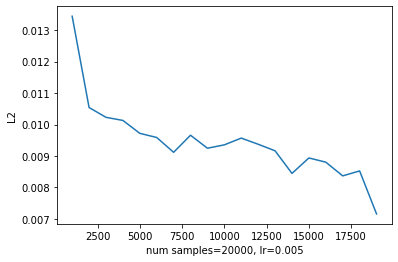

[0.013443655729293824, 0.010542063653469085, 0.0102301688157022, 0.010131466563791037, 0.009721240900456906, 0.009589083604514598, 0.009118412820622325, 0.00966078470274806, 0.009247796531766652, 0.009354945598170161, 0.009569866040721535, 0.00937391826324165, 0.009165796846151352, 0.008447236399166285, 0.008938230456784367, 0.008804775225929916, 0.00836861289292574, 0.00852658714633435, 0.007159324605949223]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[-30. -24. -18. -12.  -6.   0.   6.  12.  18.  24.  30.]


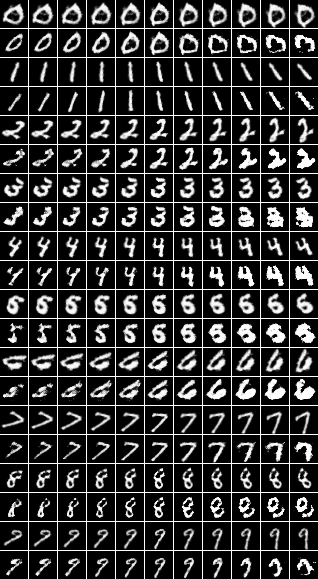

In [16]:
num_samples = 10

# a = np.linspace(-180,180, 11)
a = np.linspace(-30,30,11)
zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Error'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -27.00, dist 0.01 +/- 0.00
alpha: -21.00, dist 0.01 +/- 0.01
alpha: -15.00, dist 0.01 +/- 0.01
alpha: -9.00, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.02 +/- 0.01
alpha: 3.00, dist 0.02 +/- 0.01
alpha: 9.00, dist 0.02 +/- 0.01
alpha: 15.00, dist 0.02 +/- 0.01
alpha: 21.00, dist 0.02 +/- 0.01
alpha: 27.00, dist 0.02 +/- 0.01


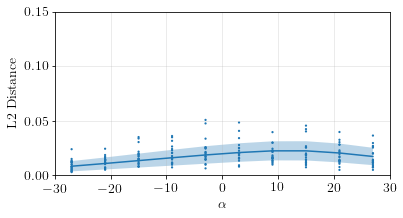

In [22]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/rot2d'
savefile_transform_effect = file_name+'_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_transform_effect + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_transform_effect + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [23]:
dist_trained_joint = np.load(os.path.join(output_dir, 'rot2d_aug_argminGW_alphamax20_lr0.0002_loss_trained_plots.npy'))
dist_trained_NoAug_argminGW = np.load(os.path.join(output_dir, 'rot2d_NoAug_argminGW_alpahmax20_lr0.0002_loss_trained_plots.npy'))
dist_trained_NoAug_argminW = np.load(os.path.join(output_dir, 'rot2d_NoAug_argminW_alphamax20_lr0.0002_loss_trained_plots.npy'))
                                     

alpha: -30.00, dist 0.07 +/- 0.01
alpha: -24.00, dist 0.06 +/- 0.01
alpha: -18.00, dist 0.04 +/- 0.01
alpha: -12.00, dist 0.03 +/- 0.00
alpha: -6.00, dist 0.01 +/- 0.00
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 6.00, dist 0.01 +/- 0.00
alpha: 12.00, dist 0.04 +/- 0.00
alpha: 18.00, dist 0.07 +/- 0.01
alpha: 24.00, dist 0.10 +/- 0.01
alpha: 30.00, dist 0.12 +/- 0.01


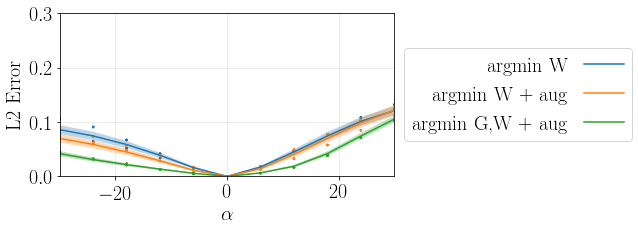

In [50]:
## plots and saves the computed similarity matrix

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20}) # 1. font size
rc('text', usetex=True)

output_dir = './out/plots/rot2d'
savefile_loss = file_name+'_loss_trained_plots'

alphas = alphas_no_log

ylabel = 'L2 Error' # 2. ylabel

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
# mu = np.mean(dist_trained_info, axis=0)
# sd = np.std(dist_trained_info, axis=0)
# p = ax.plot(xaxis, mu)
# ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
# xscatter = np.tile(xaxis, (20, 1))
# yscatter = dist_trained_info[:20] # take the first 20 samples
# ax.scatter(xscatter, yscatter, marker='.',
#            edgecolors='none', s=20, color=p[0].get_color())


### For noaug + walk
mu_j = np.mean(dist_trained_NoAug_argminW, axis=0)
sd_j = np.std(dist_trained_NoAug_argminW, axis=0)
p_j = ax.plot(xaxis, mu_j, label='argmin W') 
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_NoAug_argminW[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

# ### For noaug + joint
# mu_j = np.mean(dist_trained_NoAug_argminGW, axis=0)
# sd_j = np.std(dist_trained_NoAug_argminGW, axis=0)
# p_j = ax.plot(xaxis, mu_j)
# ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
# xscatter_j = np.tile(xaxis, (20,1))
# yscatter_j = dist_trained_NoAug_argminGW[:20]
# ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

### For shift aug+walk (this file)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu, label='argmin W + aug')
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
### For shift join
mu_j = np.mean(dist_trained_joint, axis=0)
sd_j = np.std(dist_trained_joint, axis=0)
p_j = ax.plot(xaxis, mu_j, label='argmin G,W + aug')
ax.fill_between(xaxis, mu_j-sd_j, mu_j+sd_j, alpha=0.3)
xscatter_j = np.tile(xaxis, (20,1))
yscatter_j = dist_trained_joint[:20]
ax.scatter(xscatter_j, yscatter_j, marker='.', edgecolors='none', s=20, color=p_j[0].get_color())

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
leg=ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
# ax.legend()

vp = leg._legend_box._children[-1]._children[0]
for c in vp._children:
    c._children.reverse()
vp.align='right'

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_loss + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_loss + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [29]:
ylabel

'L2 Distance'

In [ ]:
np.save(os.path.join(output_dir, savefile_transform_effect+'.npy'), dist_info)
np.save(os.path.join(output_dir, savefile_loss+'.npy'), dist_trained_info)